In [1]:
import math
import os
import seaborn as sns

from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from math import ceil, floor
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.distributions import Normal
from scipy.stats import rv_discrete


In [2]:
def get_jain_index(resources):
    """Calculates the Jain index of a list of resources."""

    # Jain fairness index
    # index close to 1 means fair distribution of resources
    # index close to 1/n means unfait distribution of resources

    n = resources.shape[0]
    r = resources

    if n <= 1:
        return 1.0
    else:
        return ((np.sum(r) ** 2) / (np.sum(r ** 2) * n))
    

def get_jain_index_max(np, nc):
    """Calculates the maximum possible value of the Jain index."""
    x = nc/np
    d = x - int(x)
    index = (1 + d*(1-d)/(x*x))**-1
    return index

In [3]:
# Identify which device should be used by torch for the ANN calculations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class AgentNet(nn.Module):
    def __init__(self, n_players, n_coins):
        super(AgentNet, self).__init__()
        self.n_players = n_players
        self.n_coins = n_coins
        self.n_actions = 2 # 0 non do soldi, 1 do soldi
        h_size = int(n_coins)
        a_size = self.n_actions
        self.fc1 = nn.Linear(n_coins+1, h_size)
        self.fc2 = nn.Linear(h_size, a_size)
        self.epsilon = 0.1
        self._gamma = 0.99

    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        
        return out

    def act(self, state):
        
        state = torch.from_numpy(state).unsqueeze(dim=0).to(device)
        state = F.one_hot(state, num_classes=self.n_coins+1).float()
        
        probs_total = self.forward(state).cpu()
        probs_total = F.softmax(probs_total, dim=1)
        
        m = Categorical(probs_total)

        action = m.sample()

        return action, m.log_prob(action), probs_total

/home/nicole/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
class Environment:

    def __init__(self, n_players, n_total_coins, threshold = 0., multiplier = 1.):
        self.n_players = n_players
        self.n_total_coins = n_total_coins
        self.state = np.zeros((self.n_players,1))
        self.threshold = threshold
        self.multiplier = multiplier
        self.rews_dict = {k: [] for k in range(self.n_players)}

    def reset(self):
        self.state = np.zeros(self.n_players)
        self.rews_dict = {k: [] for k in range(self.n_players)}
        
    def equal_division(self):
        self.coins = [int(self.n_total_coins/self.n_players) for i in range(self.n_players)]
        return self.coins
    
    def update_rews_dict(self, rew, t):
        for i in range(self.n_players):
            self.rews_dict[i].append(rew[i])
            
    def sample(self):
        left_coins = self.n_total_coins
        self.coins = []
        
        for i in range(self.n_players):
            if (i == self.n_players - 1):
                self.coins.append(left_coins)
            else:
                val = int(np.random.choice(left_coins-1, 1))
                self.coins.append(val)
                left_coins = left_coins - val 
                
        return self.coins

    def step(self, coins, actions):
        rewards = np.zeros(self.n_players)
        
        if (np.sum(actions)) < self.threshold:
            return rewards
        
        amount = np.sum([coins[i] for i in range(self.n_players) if actions[i] == 1])
            
        for i in range(self.n_players):
            if (actions[i] == 1.):
                rewards[i] = amount/self.n_players*self.multiplier
            else:
                rewards[i] = amount/self.n_players*self.multiplier + coins[i]
                
            # trick to avoid log(0) 
            if rewards[i] <= 0:
                rewards[i] = 1e-6

        return rewards

In [5]:
def reinforce_players(n_players=5, n_coins=10, n_episodes=1, print_every=1, threshold=0., multiplier=1.):
    torch.autograd.set_detect_anomaly(True)
    
    env = Environment(n_players, n_coins, threshold, multiplier)
    
    agents = {}
    opts = {}
    for i in range(n_players):
        agents[i] = AgentNet(n_players, n_coins)
        opts[i] = optim.Adam(agents[i].parameters(), lr=0.01)
    
    history = {
        "loss": [],
        "mean_rew":[],
        "jain_idx":[]
    }
    
    history_rewards = {
        "rew_0": [],
        "rew_1": [],
        "rew_2": []
    }

    for e in range(n_episodes):
        
        env.reset()
        coins = env.sample()
        #print("Coins=", coins)
        actions = []
        log_probs = []

        for agent_idx, ag in agents.items():

            a, log_prob, _ = ag.act(np.array(int(coins[agent_idx])))
            actions.append(a.detach().numpy())
            log_probs.append(log_prob)
             
        rewards = env.step(coins, actions)
        for idx, r in enumerate(rewards):
            history_rewards["rew_"+str(idx)].append(rewards[idx])
        
        losses = []
        for rew, log_prob in zip(rewards, log_probs):
            losses.append(-log_prob*rew)
            
        history["loss"].append(np.mean([l.detach().numpy() for l in losses]))       
        history["mean_rew"].append(np.mean(rewards))
        history["jain_idx"].append(get_jain_index(rewards))
                    
        for idx, loss in enumerate(losses):
            opts[idx].zero_grad()
            loss.backward()
            opts[idx].step()
            
        if (e%500 == 0):
            print("\nEpisode=", e)
            temp=[l.detach().numpy() for l in losses]
            print("losses=", np.mean(temp))
            
    return history, agents, history_rewards

In [6]:
n_episodes = 3000

n_players = 3
n_coins = 9

threshold = 0.
multiplier = 2.

history, agents, hr = reinforce_players(n_players=n_players, n_coins=n_coins, n_episodes=n_episodes, threshold = threshold, multiplier=multiplier)


Episode= 0
losses= 2.8918972

Episode= 500
losses= 4.238558

Episode= 1000
losses= 0.027468681

Episode= 1500
losses= 0.021384656

Episode= 2000
losses= 0.0021131693

Episode= 2500
losses= 0.0010247658


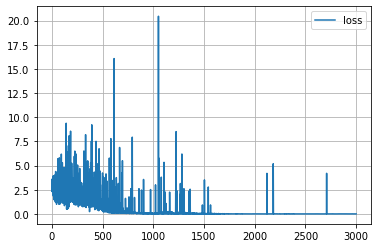

In [7]:
plt.plot(np.linspace(0, n_episodes, n_episodes), history["loss"], label='loss')
plt.legend()
plt.grid()
plt.show()

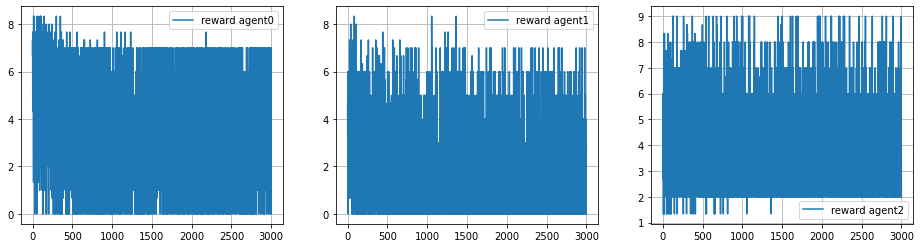

In [9]:
figure, ax = plt.subplots(1, n_players, figsize=(16, 4))

for i in range(n_players):
    ax[i].plot(np.linspace(0, n_episodes, n_episodes), hr["rew_"+str(i)], label='reward agent'+str(i))
    ax[i].legend()
    ax[i].grid()
plt.show()

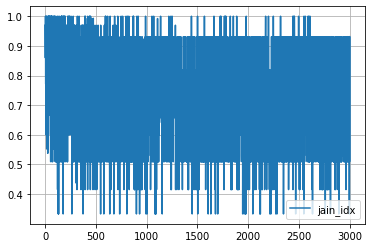

In [10]:
plt.plot(np.linspace(0, n_episodes, n_episodes), history["jain_idx"], label='jain_idx')
plt.legend()
plt.grid()
plt.show()

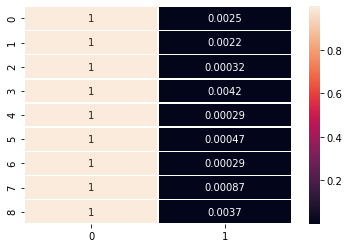

In [11]:
probbs = np.zeros((n_coins, 2))

for c in range(n_coins):
    a, log_prob, probs = agents[0].act(np.array(c))
    probbs[c] = probs.detach().numpy()
    
ax = sns.heatmap(probbs, annot=True, linewidth=.5)

Idea: aggiungi due tipi di reward: uno alto, che si guadagnano subito, ed uno che infierisce a lungo, ma costantemente, e se continuano col behavior "male", li porta ad avere piu perdite che gudagni alla fine (es. guidatori: veocita di spostamento ma aria inwuinata nel lungo termine)
        